# EDA & Preprocessing for IU X-Ray Dataset
This notebook performs exploratory data analysis (EDA) and preprocessing on the IU X-Ray dataset. After running this, a cleaned CSV (`merged_preprocessed.csv`) will be saved for use in the full training pipeline.

In [1]:
!pip install pandas numpy matplotlib pillow tqdm --quiet

In [2]:
from google.colab import drive

# Mount the root Google Drive directory first
drive.mount('/content/drive')

# Then, you can access your specific folder within the Drive
import os
# Create the target directory if it doesn't exist
DATA_DIR = '/content/drive/MyDrive/IU-Xray' # Assuming your Drive path is 'MyDrive/IU-Xray'
if not os.path.exists(DATA_DIR):
  os.makedirs(DATA_DIR)

print(f"IU-Xray directory is mounted at: {DATA_DIR}")

Mounted at /content/drive
IU-Xray directory is mounted at: /content/drive/MyDrive/IU-Xray


In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# Load CSVs
reports_df = pd.read_csv(f"{DATA_DIR}/indiana_reports.csv")
proj_df    = pd.read_csv(f"{DATA_DIR}/indiana_projections.csv")

# Filter for frontal views and merge
frontal = proj_df[proj_df['projection'] == 'Frontal']
merged = reports_df.merge(frontal, on='uid').dropna(subset=['MeSH', 'filename', 'indication', 'impression']).reset_index(drop=True)
print("Total samples:", len(merged))
merged.head()

Total samples: 3727


,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-4001.dcm.png,Frontal
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-1001.dcm.png,Frontal
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...",3_IM-1384-1001.dcm.png,Frontal
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,4_IM-2050-1001.dcm.png,Frontal
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.,5_IM-2117-1003002.dcm.png,Frontal


In [5]:
!pip install --upgrade torchxrayvision

In [6]:
# Define CheXpert label list
import torchxrayvision as xrv
chexpert_labels = xrv.models.DenseNet(weights="densenet121-res224-chex").pathologies
print("CheXpert labels:", chexpert_labels)

/usr/local/lib/python3.11/dist-packages/torchxrayvision/utils.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


CheXpert labels: ['Atelectasis', 'Consolidation', '', 'Pneumothorax', 'Edema', '', '', 'Effusion', 'Pneumonia', '', 'Cardiomegaly', '', '', '', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']


In [7]:
def map_mesh_to_chexpert(mesh_string):
    terms = [m.strip().lower() for m in mesh_string.split(';') if m.strip()]
    matches = [lbl for lbl in chexpert_labels if any(lbl.lower() in t for t in terms)]
    return matches

# Example mapping
print(map_mesh_to_chexpert(merged.loc[0, 'MeSH']))


['', '', '', '', '', '', '']


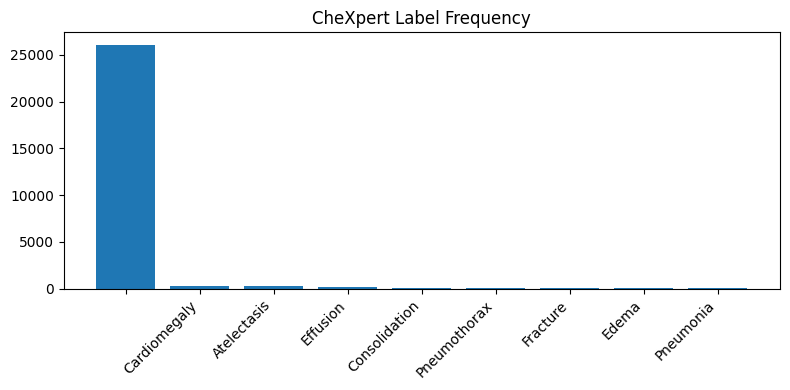

In [8]:
# Compute label distribution
from collections import Counter
all_mapped = merged['MeSH'].apply(map_mesh_to_chexpert)
counter = Counter([lbl for sub in all_mapped for lbl in sub])

# Plot distribution
plt.figure(figsize=(8,4))
plt.bar(counter.keys(), counter.values())
plt.xticks(rotation=45, ha='right')
plt.title("CheXpert Label Frequency")
plt.tight_layout()
plt.show()

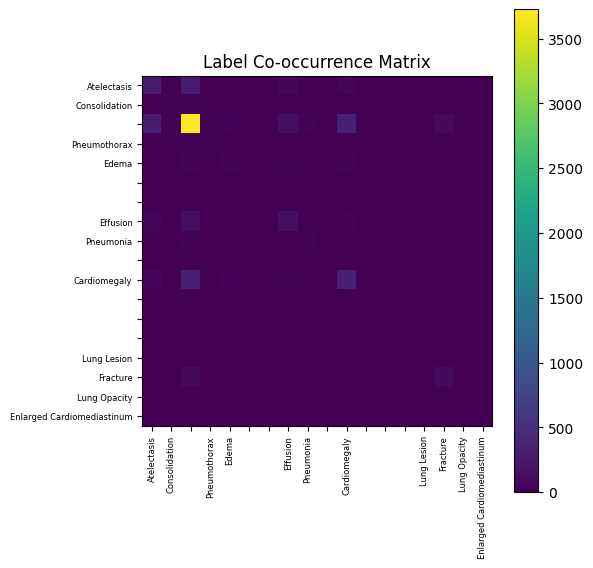

In [9]:
# Build co-occurrence matrix
binary = np.zeros((len(merged), len(chexpert_labels)), dtype=int)
for i, mesh in enumerate(merged['MeSH']):
    labs = map_mesh_to_chexpert(mesh)
    for lbl in labs:
        binary[i, chexpert_labels.index(lbl)] = 1

co_mat = binary.T.dot(binary)
plt.figure(figsize=(6,6))
plt.imshow(co_mat)
plt.colorbar()
plt.title("Label Co-occurrence Matrix")
plt.xticks(range(len(chexpert_labels)), chexpert_labels, rotation=90, fontsize=6)
plt.yticks(range(len(chexpert_labels)), chexpert_labels, fontsize=6)
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


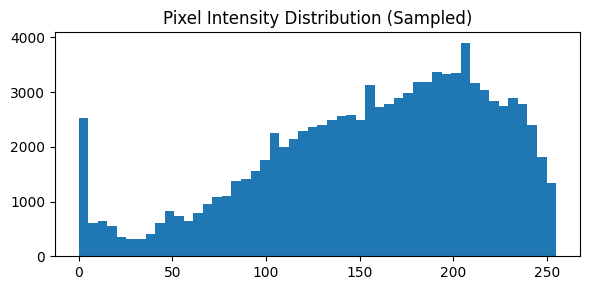

In [10]:
import random

files = merged['filename'].unique()
sample_files = files[:100]
pixels = []

for fn in tqdm(sample_files):
    img_path = os.path.join(DATA_DIR, 'images', 'images_normalized', fn)
    img = Image.open(img_path).convert('L')
    img_arr = np.array(img).flatten()

    # Sample only 1000 pixels per image to avoid memory overload
    if len(img_arr) > 1000:
        pixels.extend(random.sample(list(img_arr), 1000))
    else:
        pixels.extend(img_arr)

plt.figure(figsize=(6, 3))
plt.hist(pixels, bins=50)
plt.title("Pixel Intensity Distribution (Sampled)")
plt.tight_layout()
plt.show()

Adjusted the number of pixels from 10 million+ to 100,000+

This is done because of hardware constraints. More pixel data will lead to better results. As of now everything is optimized for proof of concept on a low level hardware.

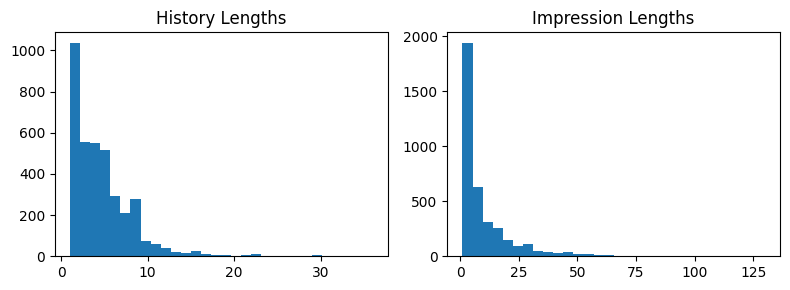

In [11]:
# Compute text lengths
merged['hist_len'] = merged['indication'].str.split().apply(len)
merged['imp_len']  = merged['impression'].str.split().apply(len)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(merged['hist_len'], bins=30)
plt.title("History Lengths")
plt.subplot(1,2,2)
plt.hist(merged['imp_len'], bins=30)
plt.title("Impression Lengths")
plt.tight_layout()
plt.show()

In [12]:
# Text cleaning function
def clean_text(s):
    return ''.join(ch for ch in s if ord(ch) < 128).strip().lower()

# Apply cleaning and mapping
merged['indication_clean'] = merged['indication'].apply(clean_text)
merged['impression_clean']  = merged['impression'].apply(clean_text)
merged['mesh_terms']        = merged['MeSH'].apply(lambda s: ';'.join([m.strip() for m in s.split(';')]))
merged['chexpert_labels']   = merged['MeSH'].apply(lambda s: ';'.join(map_mesh_to_chexpert(s)))

# Select columns and save
preproc = merged[['uid','filename','projection','indication_clean','impression_clean','mesh_terms','chexpert_labels']]
preproc.to_csv(f"{DATA_DIR}/merged_preprocessed.csv", index=False)
print("Saved preprocessed data to merged_preprocessed.csv")
preproc.head()

Saved preprocessed data to merged_preprocessed.csv


,uid,filename,projection,indication_clean,impression_clean,mesh_terms,chexpert_labels
0,1,1_IM-0001-4001.dcm.png,Frontal,positive tb test,normal chest x-xxxx.,normal,;;;;;;
1,2,2_IM-0652-1001.dcm.png,Frontal,preop bariatric surgery.,no acute pulmonary findings.,Cardiomegaly/borderline;Pulmonary Artery/enlarged,;;;;Cardiomegaly;;;
2,3,3_IM-1384-1001.dcm.png,Frontal,"rib pain after a xxxx, xxxx xxxx steps this xx...","no displaced rib fractures, pneumothorax, or p...",normal,;;;;;;
3,4,4_IM-2050-1001.dcm.png,Frontal,xxxx-year-old xxxx with xxxx.,1. bullous emphysema and interstitial fibrosis...,"Pulmonary Disease, Chronic Obstructive;Bullous...",;;;;;;
4,5,5_IM-2117-1003002.dcm.png,Frontal,chest and nasal congestion.,no acute cardiopulmonary abnormality.,Osteophyte/thoracic vertebrae/multiple/small;T...,;;;;;;


#This is the fixed EDA and label mapping.

In [6]:
!pip install fuzzywuzzy[speedup] --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.4 MB/s eta 0:00:00


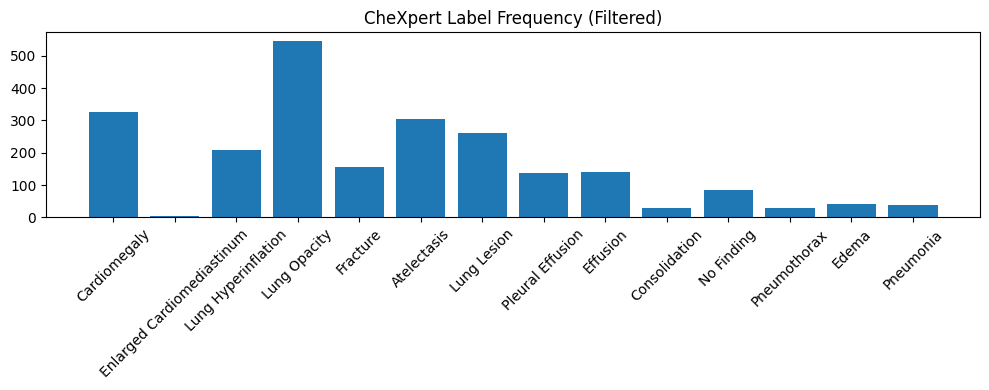

Cardiomegaly: 326
Enlarged Cardiomediastinum: 5
Lung Hyperinflation: 209
Lung Opacity: 545
Fracture: 155
Atelectasis: 303
Lung Lesion: 261
Pleural Effusion: 138
Effusion: 141
Consolidation: 28
No Finding: 86
Pneumothorax: 28
Edema: 43
Pneumonia: 38


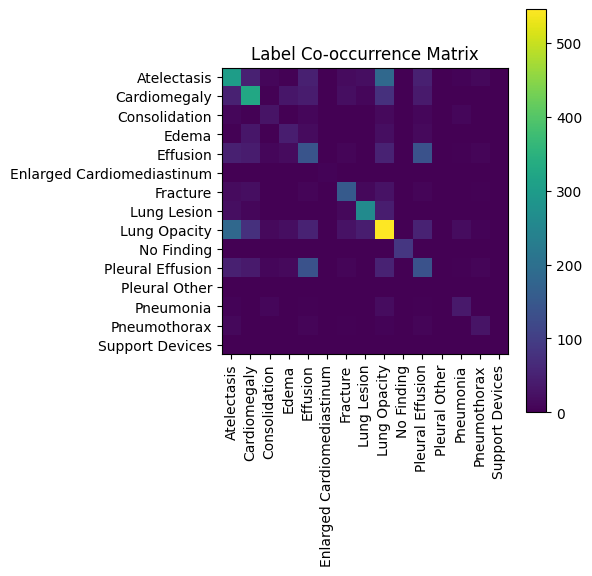

100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


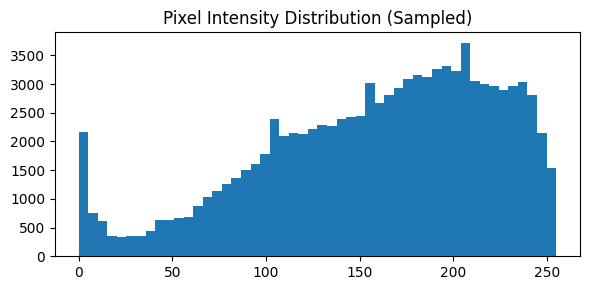

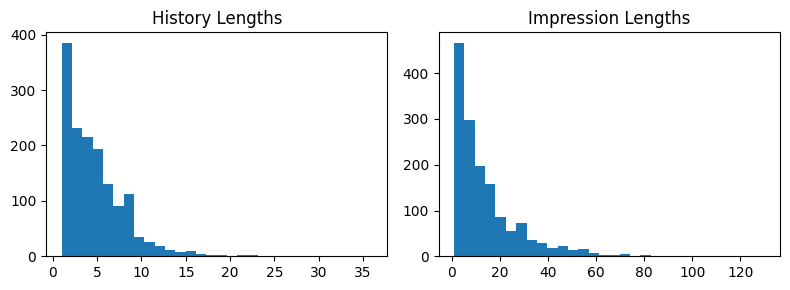

✅ Saved: merged_preprocessed.csv


In [9]:
# IU X-Ray EDA & Preprocessing (Enhanced)


# Load Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from collections import Counter
from tqdm import tqdm
import random
from fuzzywuzzy import fuzz
from collections import Counter


# Load Data
reports = pd.read_csv(os.path.join(DATA_DIR, 'indiana_reports.csv'))
projections = pd.read_csv(os.path.join(DATA_DIR, 'indiana_projections.csv'))
# Filter for Frontal views only
projections = projections[projections['projection'] == 'Frontal']
# Merge
merged = reports.merge(projections, on='uid').dropna(subset=['MeSH', 'filename', 'indication', 'impression']).reset_index(drop=True)



# Load CheXpert labels from reference
chexpert_labels = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
    'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
    'Pneumothorax', 'Support Devices'
]



# Expanded manual mapping
MANUAL_MAP = {
    'pulmonary fibrosis': 'Lung Opacity',
    'interstitial fibrosis': 'Lung Opacity',
    'hyperinflation': 'Lung Hyperinflation',
    'atelectasis/base': 'Atelectasis',
    'opacity/pulmonary alveoli': 'Lung Opacity',
    'pulmonary edema': 'Edema',
    'pleural effusion': 'Effusion',
    'osteophyte': 'Fracture',
    'cicatrix': 'Lung Opacity',
    'calcified granuloma': 'Lung Lesion',
    'lung/hyperdistention': 'Lung Hyperinflation',
    'bullous emphysema': 'Lung Hyperinflation',
    'cardiomegaly/borderline': 'Cardiomegaly',
    'pulmonary artery/enlarged': 'Enlarged Cardiomediastinum',
    'opacity': 'Lung Opacity',
    'effusion': 'Effusion'
}



def map_mesh_to_chexpert(mesh_terms):
    terms = [t.strip().lower() for t in mesh_terms.split(';') if t.strip()]
    mapped = set()
    for t in terms:
        for lbl in chexpert_labels:
            if lbl.lower() in t or fuzz.token_sort_ratio(lbl.lower(), t) >= 70:
                mapped.add(lbl)
        for k, v in MANUAL_MAP.items():
            if k in t:
                mapped.add(v)
    return list(mapped)


# Apply mapping and clean text fields
merged['indication_clean'] = merged['indication'].str.lower().str.replace(r'[^\x00-\x7F]+',' ').str.strip()
merged['impression_clean'] = merged['impression'].str.lower().str.replace(r'[^\x00-\x7F]+',' ').str.strip()
merged['mesh_terms'] = merged['MeSH'].fillna('')
merged['chexpert_labels'] = merged['mesh_terms'].apply(map_mesh_to_chexpert)
merged = merged[merged['chexpert_labels'].apply(lambda x: len(x) > 0)].reset_index(drop=True)



# Label Distribution
label_counts = Counter([lbl for lst in merged['chexpert_labels'] for lbl in lst])
plt.figure(figsize=(10,4))
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(rotation=45)
plt.title("CheXpert Label Frequency (Filtered)")
plt.tight_layout()
plt.show()



# Compute label frequencies
label_counts = Counter([lbl for lst in merged['chexpert_labels'] for lbl in lst])

# Convert to dictionary
label_freq_dict = dict(label_counts)

# Display it
for label, count in label_freq_dict.items():
    print(f"{label}: {count}")


# Co-occurrence Matrix
binary = np.zeros((len(merged), len(chexpert_labels)), dtype=int)
for i, labels in enumerate(merged['chexpert_labels']):
    for lbl in labels:
        if lbl in chexpert_labels:
            binary[i, chexpert_labels.index(lbl)] = 1
co_mat = binary.T.dot(binary)
plt.figure(figsize=(6,6))
plt.imshow(co_mat)
plt.colorbar()
plt.title("Label Co-occurrence Matrix")
plt.xticks(range(len(chexpert_labels)), chexpert_labels, rotation=90)
plt.yticks(range(len(chexpert_labels)), chexpert_labels)
plt.tight_layout()
plt.show()



# Sampled pixel intensity histogram
files = merged['filename'].unique()
sample_files = files[:100]
pixels = []

for fn in tqdm(sample_files):
    img_path = os.path.join(DATA_DIR, 'images', 'images_normalized', fn)
    img = Image.open(img_path).convert('L')
    img_arr = np.array(img).flatten()
    if len(img_arr) > 1000:
        pixels.extend(random.sample(list(img_arr), 1000))
    else:
        pixels.extend(img_arr)

plt.figure(figsize=(6,3))
plt.hist(pixels, bins=50)
plt.title("Pixel Intensity Distribution (Sampled)")
plt.tight_layout()
plt.show()



# Text Lengths
merged['hist_len'] = merged['indication_clean'].str.split().apply(len)
merged['imp_len'] = merged['impression_clean'].str.split().apply(len)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(merged['hist_len'], bins=30)
plt.title("History Lengths")
plt.subplot(1,2,2)
plt.hist(merged['imp_len'], bins=30)
plt.title("Impression Lengths")
plt.tight_layout()
plt.show()



# Export cleaned dataset
final = merged[['uid','filename','projection','indication_clean','impression_clean','mesh_terms','chexpert_labels']]
final.to_csv(os.path.join(DATA_DIR, 'merged_preprocessed.csv'), index=False)
print("✅ Saved: merged_preprocessed.csv")


As we can see here that the label mapping is much more balanced now. We have 14 distinct classes instead of just 1 class dominating. This makes training much better and even.